In [1]:
%matplotlib inline
# notebook to attempt the fingerprinting process before committing it to an actual structure/file

import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from Tools.wavehelper import WaveHelper

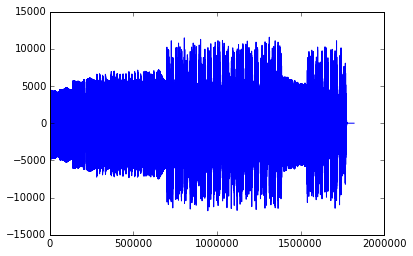

In [2]:
w = WaveHelper("Samples/337653__hmmm101__pixel-song-19.wav")
aud = w.read_whole()
plt.plot(aud)
plt.show()

length of audio: 1818752, length of fft: 1818752


/usr/lib/python3/dist-packages/numpy/core/numeric.py:460: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


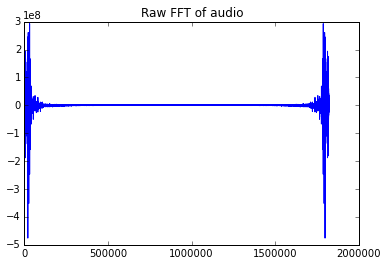

In [3]:
fft_raw = fft(aud)
print("length of audio: {}, length of fft: {}".format(len(aud), len(fft_raw)))
plt.plot(fft_raw)
plt.title("Raw FFT of audio")
plt.show()

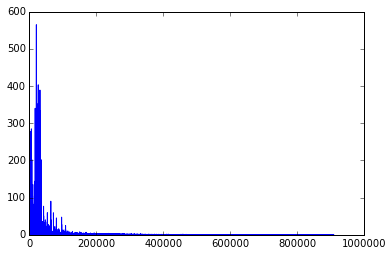

In [4]:
# we need to chop this up until half the values discarding the (imaginary)? part
# the internet says we also need to plot 2/len(arr) * np.abs(arr)
fft_pretty = 2/len(fft_raw) * np.abs(fft_raw[:len(fft_raw)//2])
plt.plot(fft_pretty)
plt.show()

xf: 909376, fft_pretty: 909376


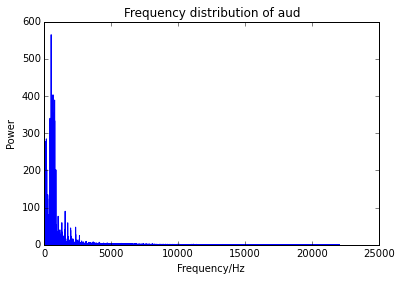

In [5]:
# what concerns me with this plot is that we get "frequencies" up until N/2
# whereas the audio won't have a higher sample rate than 44.1kHz
# ie max recognisable frequency is 22.05kHz
# http://stackoverflow.com/questions/604453/analyze-audio-using-fast-fourier-transform says that the above plot
# is just the frequency coefficients and I need to map that to the actual frequency spacing
# freq spacing = fsample / npoints
f_space = w.rate / len(fft_raw)
xf = np.linspace(0, w.rate/2, len(fft_raw)/2) # 3rd argument is number of samples
print("xf: {}, fft_pretty: {}".format(len(xf), len(fft_pretty)))
plt.plot(xf, fft_pretty)
plt.title("Frequency distribution of aud")
plt.ylabel("Power")
plt.xlabel("Frequency/Hz")
plt.show()

([715, 716], [11.0, 14.5])


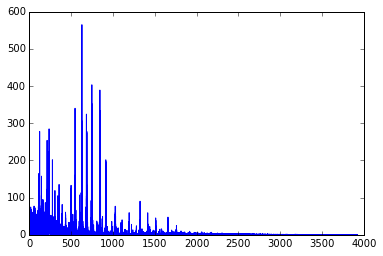

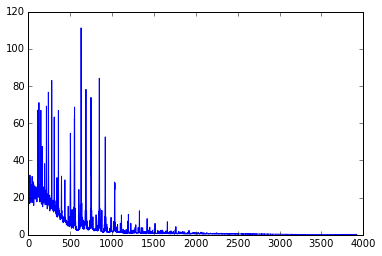

In [8]:
# now we want to get the mel scale representation

def to_mel(iterable):
    """ uses equation from https://en.wikipedia.org/wiki/Mel_scale"""
    return 2595 * np.log10(1 + (iterable/700))

def to_int_version(xlist, ylist):
    """ Given a list of x values and a list of y values it will produce new lists
        where the x values have all been rounded to the nearest integers and the
        corresponding y values averaged.
        [715.2364, 715.3462, 715.5693, 716.2054], [12, 10, 13, 16] would produce
        [715, 716], [11, 14.5]
        Credit to Michael Hart for the original function.
    """
    d = []
    prev = 0
    new_y = []
    new_x = []
    for idx, x in enumerate(xlist):
        if round(x) != prev:
            if d != []:
                new_y.append(np.mean(d))
                new_x.append(prev)
            prev = int(round(x))
            d = []
        d.append(ylist[idx])
    new_y.append(np.mean(d))
    new_x.append(prev)
    return new_x, new_y

print(to_int_version([715.2364, 715.3462, 715.5693, 716.2054], [12, 10, 13, 16]))

mel = to_mel(xf)
plt.plot(mel, fft_pretty)
plt.show()
newmel, newy = to_int_version(mel, fft_pretty)
plt.plot(newmel, newy)
plt.show()

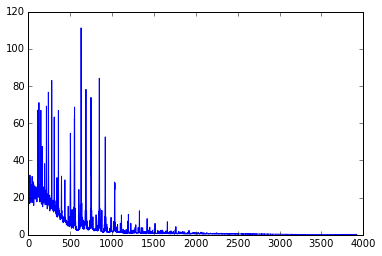

In [11]:
# taking the above, we can define an fft function
def get_frequencies(aud, l_aud, s_rate):
    yf = 2/l_aud * np.abs(fft(aud)[:l_aud//2])
    xf = np.linspace(0, s_rate/2, l_aud/2)
    mel = to_mel(xf)
    return to_int_version(mel, yf)

get_freq_res = get_frequencies(aud, len(aud), w.rate)
# unpacking the tuple into the arguments to plt.plot gets us the same as above
plt.plot(*get_freq_res)
plt.show()

In [12]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

mili_per_chunk = 16

sgram = []
s_per_n = w.samples_per_n_mili(mili_per_chunk)

count = 1
for chunk in chunks(aud, s_per_n):
    sgram.append(get_frequencies(chunk, s_per_n, w.rate))
    print("\rChunk {}".format(count), end='')
    count += 1
print()

# all frequency scales are the same

freq_scales = []
for thing in sgram:
    if not (thing[0] in freq_scales):
        freq_scales.append(thing[0])

print(len(freq_scales))
print(sgram[0][0][:10])

Chunk 2580
1
[0, 97, 186, 269, 346, 418, 485, 549, 610, 667]


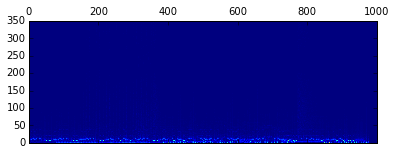

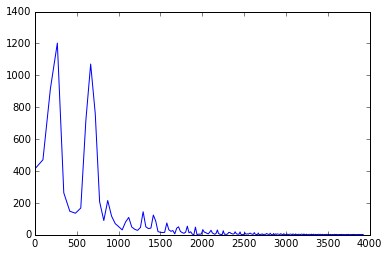

In [13]:
sgram_y = [sg[1] for sg in sgram]
# the below line makes no sense
plt.matshow(np.array(sgram_y).T, origin="lower", extent=[0, 1000, 0, 350])
plt.show()

plt.plot(sgram[0][0], sgram_y[0])
plt.show()

In [14]:
# generating constellation map
# we need to get points with the largest amplitude
# this should be done per region to aid time invariance aspect
# density criterion should be an adjustable parameter
# how large should the region be? make adj param

density = 0.02 # ie top 2% of points
n_windows = 5
window_l = len(sgram_y[0])

# number of points that each region should have
points_per_chunk = int(window_l * n_windows * density)
print(points_per_chunk, "points per chunk")

count = 0
# max_idxs is a list of (time: ms, frequency: mel)
max_idxs = []
for window in chunks(sgram_y, n_windows):
    # flatten the multiple windows into a one dimensional list
    flat = [item for sublist in window for item in sublist]
    # get top points for that chunk
    sort = sorted(flat, reverse=True)[:points_per_chunk]
    for item in sort:
        # x is which window it forms part of
        x = count + int(flat.index(item)/window_l)
        # y is how far along the frequency spectrum it is
        y = flat.index(item) % window_l
        max_idxs.append((x * mili_per_chunk, sgram[0][0][y]))
    count += n_windows
print(len(max_idxs), "items, first from first 10 are", max_idxs[:350:points_per_chunk])

35 points per chunk
18060 items, first from first 10 are [(64, 667), (128, 667), (160, 667), (240, 774), (352, 774), (416, 871), (544, 871), (624, 774), (640, 774), (752, 774)]


In [15]:
# hashing the constellation map
# first we select anchor points
# (strongest in the region for now as paper says nothing about selection itself)
# These anchor points are matched to all points in a target zone
# each point pair gets combined into a hash
# this hash gets added to the time offset and track ID to generate a 64 bit struct
# these structs when stored are sorted based on the hash

from itertools import product
import sys

print("Frequency range is", sgram[0][0][0], sgram[0][0][-1])
# as we are working with audible sound here, we can limit the mel frequency to 4000 safely
# this means that we need 12 bits to store each of the frequency components
print("Time range is", 0, mili_per_chunk * len(sgram_y))
# If we were to store window number, that would be smaller (3 bits in this case)
# but it would lock us into the same size window for each database
# this could be solved by storing window size with the table somehow, but that would be more lookups
# as such we shall store miliseconds instead
# for the time delta it can be fairly safely assumed that it will be under 1 second and so will fit in 10 bits
# the length of t1 could be pretty much anything, but you can limit it by limiting what length
# of audio the application accepts. In this case 22 bits will give 1 hour's worth of audio (2^22/60000)
# which is almost certainly good enough for a music retrieval service and will round each hash nicely up to 56 bits

def pad(s, length):
    """ Takes a string and pads the start with 0s if less than length """
    num = length - len(s)
    if num <= 0:
        return s
    return ("0" * num) + s

def hashed(pair):
    # pair is defined as ((t1: ms, f1: mel), (t2: ms, f2: mel))
    # hash is defined as f1:f2:t2-t1:t1
    """ Takes a pair of time/freq coords and returns a len 7 bytes instance hash"""
    ret = ""
    f1     = pad(bin(pair[0][1]).lstrip('-0b'), 12)
    f2     = pad(bin(pair[1][1]).lstrip('-0b'), 12)
    tdelta = pad(bin(pair[1][0] - pair[0][0]).lstrip('-0b'), 10)
    t1     = pad(bin(pair[0][0]).lstrip('-0b'), 22)
    ret += f1 + f2 + tdelta + t1
    return int(ret, 2).to_bytes((len(ret) + 7) // 8, sys.byteorder)

# since this list was generated with the max amp points first, this should work
# TODO confirm it works
idx = 0
hashes = []
for coord in max_idxs[::points_per_chunk]:
    # use next region along (if exists, if not ignore)
    idx += points_per_chunk
    hashes.append([hashed(pair) for pair in product((coord,), max_idxs[idx:idx+points_per_chunk])])

print(len(hashes))

Frequency range is 0 3923
Time range is 0 41280
516


In [16]:
for prod in product((max_idxs[0],), max_idxs[35:70]):
    print(prod)

((64, 667), (128, 667))
((64, 667), (144, 667))
((64, 667), (96, 667))
((64, 667), (80, 667))
((64, 667), (112, 667))
((64, 667), (112, 722))
((64, 667), (96, 722))
((64, 667), (80, 722))
((64, 667), (128, 722))
((64, 667), (144, 722))
((64, 667), (144, 269))
((64, 667), (80, 269))
((64, 667), (128, 610))
((64, 667), (96, 269))
((64, 667), (96, 610))
((64, 667), (128, 269))
((64, 667), (112, 186))
((64, 667), (112, 269))
((64, 667), (128, 186))
((64, 667), (112, 774))
((64, 667), (96, 186))
((64, 667), (96, 774))
((64, 667), (80, 610))
((64, 667), (80, 774))
((64, 667), (128, 774))
((64, 667), (144, 549))
((64, 667), (144, 774))
((64, 667), (80, 186))
((64, 667), (112, 97))
((64, 667), (80, 549))
((64, 667), (144, 186))
((64, 667), (112, 871))
((64, 667), (144, 346))
((64, 667), (96, 871))
((64, 667), (112, 0))
